In [9]:
import numpy as np, sys, os
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import time
import multiprocessing as mp
%matplotlib inline

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# Create corpus dataframe
corpus_df = pd.concat([pd.DataFrame([[os.path.splitext(i)[0], ' '.join(np.load('corpus/' + i).astype('U13'))]], columns=['arxiv_id', 'text']) for i in os.listdir('corpus') if i.endswith('.npy')], ignore_index=True)
corpus_df.to_csv('corpus.csv', index=False, header=True)

In [3]:
corpus = pd.read_csv('corpus.csv')
corpus

,arxiv_id,text
0,1304.4591,massive stars strongly contribute to the light...
1,1709.01527,temporal monitoring of neighboring stars e g w...
2,1406.2086,methanol masers are known to be associated wit...
3,1206.3042,meteorites are a partial sample of asteroids t...
4,1403.1103,among the alternative approaches to describe t...
5,0902.1212,r coronae borealis rcb stars are a type of eru...
6,astro-ph0404318,the wmap satellite measured an optical depth t...
7,1608.08842,the object v838 monocerotis hereafter v838 mon...
8,1403.6120,the discovery of cosmic acceleration has gener...
9,0809.4871,although sirius is the brightest star in the s...


In [4]:
# Get tokens array for each file
corpus_tokens = [str(doc).split() for doc in corpus['text']]
len(corpus_tokens)

# Remove papers with fewer than 100 tokens (any higher will remove actual papers such as 0705.3177 and 0709.0460)
# as these did not get converted correctly with latexml
doc_lens = [len(d) for d in corpus_tokens]
min_indices = [i for i, v in enumerate(doc_lens) if v < 100]
print('Dropping ' + str(len(min_indices)) + ' papers...')
corpus_df = corpus.drop(corpus.index[min_indices])
corpus_df.reset_index(drop=True)

Dropping 187 papers...


,arxiv_id,text
0,1304.4591,massive stars strongly contribute to the light...
1,1709.01527,temporal monitoring of neighboring stars e g w...
2,1406.2086,methanol masers are known to be associated wit...
3,1206.3042,meteorites are a partial sample of asteroids t...
4,1403.1103,among the alternative approaches to describe t...
5,0902.1212,r coronae borealis rcb stars are a type of eru...
6,astro-ph0404318,the wmap satellite measured an optical depth t...
7,1608.08842,the object v838 monocerotis hereafter v838 mon...
8,1403.6120,the discovery of cosmic acceleration has gener...
9,0809.4871,although sirius is the brightest star in the s...


In [5]:
# Get tokens array for each file, AGAIN (after dropping)
corpus_tokens = [doc.split() for doc in corpus_df['text']]
len(corpus_tokens)

27217

In [11]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = gensim.corpora.Dictionary(corpus_tokens)
print(dictionary)

2019-04-05 22:14:23,649 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-04-05 22:14:45,748 : INFO : adding document #10000 to Dictionary(135770 unique tokens: ['22pc', '60s', '6h', '7h', '90s']...)
2019-04-05 22:15:07,989 : INFO : adding document #20000 to Dictionary(197845 unique tokens: ['22pc', '60s', '6h', '7h', '90s']...)
2019-04-05 22:15:23,905 : INFO : built Dictionary(230166 unique tokens: ['22pc', '60s', '6h', '7h', '90s']...) from 27217 documents (total 147195047 corpus positions)


Dictionary(230166 unique tokens: ['22pc', '60s', '6h', '7h', '90s']...)


In [12]:
# Create corpus iterable to manage memory
class MyCorpus(object):
    def __iter__(self):
        for doc in corpus_df['text']:
            # Assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(doc.split())

In [13]:
corpus = MyCorpus()

Need to hold out a test set, randomly chosen. 

In [14]:
print('Running LDA on ' + str(mp.cpu_count() - 1) + ' cores')

start = time.time()
lda = gensim.models.LdaMulticore(corpus=corpus, 
                                 workers=mp.cpu_count() - 1,
                                 id2word=dictionary,
                                 num_topics=10,
                                 chunksize=10000,
                                 passes=10)
print(str(time.time() - start + 'ms')

2019-04-05 22:15:23,929 : INFO : using symmetric alpha at 0.1
2019-04-05 22:15:23,930 : INFO : using symmetric eta at 0.1
2019-04-05 22:15:23,967 : INFO : using serial LDA version on this node


Running LDA on 15 cores


2019-04-05 22:15:24,298 : WARNING : input corpus stream has no len(); counting documents
2019-04-05 22:16:24,768 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 27217 documents, updating every 15000 documents, evaluating every ~27217 documents, iterating 50x with a convergence threshold of 0.001000
2019-04-05 22:16:24,769 : INFO : training LDA model using 15 processes
2019-04-05 22:16:28,521 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/27217, outstanding queue size 1
2019-04-05 22:16:31,492 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/27217, outstanding queue size 2
2019-04-05 22:16:34,412 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #3000/27217, outstanding queue size 2
2019-04-05 22:16:37,171 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #4000/27217, outstanding queue size 2
2019-04-05 22:16:39,935 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:19:12,024 : INFO : topic #3 (0.100): 0.107*"the" + 0.051*"<latex>" + 0.037*"of" + 0.025*"in" + 0.022*"and" + 0.018*"to" + 0.018*"is" + 0.017*"a" + 0.012*"for" + 0.011*"<num>"
2019-04-05 22:19:12,029 : INFO : topic diff=0.402430, rho=0.185004
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaco

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:20:35,525 : INFO : topic #3 (0.100): 0.104*"the" + 0.054*"<latex>" + 0.037*"of" + 0.025*"in" + 0.022*"and" + 0.019*"is" + 0.019*"to" + 0.017*"a" + 0.012*"for" + 0.010*"we"
2019-04-05 22:20:35,530 : INFO : topic diff=0.331366, rho=0.181917
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
2019-04-05 22:20:37,146 : INFO : -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 217 documents with 1155974 words
2019-04-05 22:20:39,366 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #1000/27217, outstanding queue size 1
2019-

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:23:24,394 : INFO : topic #8 (0.100): 0.078*"the" + 0.050*"<latex>" + 0.038*"<num>" + 0.032*"of" + 0.028*"in" + 0.020*"and" + 0.019*"to" + 0.014*"a" + 0.013*"is" + 0.012*"for"
2019-04-05 22:23:24,399 : INFO : topic diff=0.258580, rho=0.176180
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaco

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:24:48,932 : INFO : topic #7 (0.100): 0.078*"the" + 0.036*"<latex>" + 0.035*"of" + 0.027*"<num>" + 0.025*"in" + 0.022*"to" + 0.022*"and" + 0.022*"is" + 0.020*"a" + 0.010*"we"
2019-04-05 22:24:48,936 : INFO : topic #3 (0.100): 0.099*"the" + 0.060*"<latex>" + 0.037*"of" + 0.025*"in" + 0.022*"and" + 0.020*"is" + 0.020*"to" + 0.017*"a" + 0.012*"for" + 0.011*"we"
2019-04-05 22:24:48,941 : INFO : topic #9 (0.100): 0.068*"the" + 0.061*"<num>" + 0.035*"of" + 0.028*"<latex>" + 0.025*"and" + 0.022*"in" + 0.017*"to" + 0.015*"a" + 0.011*"for" + 0.011*"is"
2019-04-05 22:24:48,946 : INFO : topic diff=0.229595, rho=0.173508
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:26:12,421 : INFO : topic #4 (0.100): 0.082*"the" + 0.055*"<num>" + 0.035*"of" + 0.029*"<latex>" + 0.023*"and" + 0.022*"in" + 0.018*"a" + 0.018*"to" + 0.015*"is" + 0.011*"with"
2019-04-05 22:26:12,426 : INFO : topic diff=0.203412, rho=0.170954
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anac

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:28:59,953 : INFO : topic #0 (0.100): 0.102*"the" + 0.042*"of" + 0.025*"in" + 0.023*"and" + 0.022*"<latex>" + 0.020*"to" + 0.018*"a" + 0.018*"is" + 0.014*"<num>" + 0.010*"for"
2019-04-05 22:28:59,958 : INFO : topic #6 (0.100): 0.089*"the" + 0.038*"of" + 0.038*"<num>" + 0.024*"in" + 0.022*"and" + 0.021*"<latex>" + 0.021*"to" + 0.019*"a" + 0.013*"is" + 0.010*"for"
2019-04-05 22:28:59,963 : INFO : topic #4 (0.100): 0.082*"the" + 0.057*"<num>" + 0.035*"of" + 0.029*"<latex>" + 0.023*"and" + 0.022*"in" + 0.018*"a" + 0.017*"to" + 0.014*"is" + 0.011*"with"
2019-04-05 22:28:59,968 : INFO : topic diff=0.159245, rho=0.166167
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/ho

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

2019-04-05 22:30:22,765 : INFO : topic #6 (0.100): 0.089*"the" + 0.038*"of" + 0.037*"<num>" + 0.024*"in" + 0.023*"and" + 0.021*"to" + 0.020*"<latex>" + 0.019*"a" + 0.014*"is" + 0.010*"for"
2019-04-05 22:30:22,770 : INFO : topic diff=0.140883, rho=0.163919
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaco

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/ec2-user/anaconda2/envs/py37/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

-901.0984880924225ms


In [16]:
print(lda.print_topics(num_topics=10, num_words=50))

2019-04-05 22:31:32,591 : INFO : topic #0 (0.100): 0.102*"the" + 0.042*"of" + 0.025*"in" + 0.023*"and" + 0.022*"<latex>" + 0.020*"to" + 0.018*"a" + 0.018*"is" + 0.014*"<num>" + 0.010*"for" + 0.009*"that" + 0.009*"with" + 0.009*"by" + 0.008*"are" + 0.007*"this" + 0.007*"we" + 0.006*"be" + 0.006*"as" + 0.006*"from" + 0.006*"at" + 0.005*"energy" + 0.005*"on" + 0.004*"which" + 0.004*"an" + 0.003*"magnetic" + 0.003*"field" + 0.003*"it" + 0.003*"can" + 0.003*"shock" + 0.003*"model" + 0.003*"not" + 0.003*"density" + 0.002*"have" + 0.002*"these" + 0.002*"al" + 0.002*"than" + 0.002*"data" + 0.002*"our" + 0.002*"or" + 0.002*"where" + 0.002*"et" + 0.002*"between" + 0.002*"time" + 0.002*"flux" + 0.002*"region" + 0.002*"also" + 0.002*"has" + 0.002*"figure" + 0.002*"velocity" + 0.002*"two"
2019-04-05 22:31:32,596 : INFO : topic #1 (0.100): 0.082*"the" + 0.041*"of" + 0.029*"<latex>" + 0.024*"in" + 0.021*"and" + 0.020*"to" + 0.020*"a" + 0.016*"is" + 0.014*"<num>" + 0.011*"that" + 0.011*"for" + 0.011*"

[(0, '0.102*"the" + 0.042*"of" + 0.025*"in" + 0.023*"and" + 0.022*"<latex>" + 0.020*"to" + 0.018*"a" + 0.018*"is" + 0.014*"<num>" + 0.010*"for" + 0.009*"that" + 0.009*"with" + 0.009*"by" + 0.008*"are" + 0.007*"this" + 0.007*"we" + 0.006*"be" + 0.006*"as" + 0.006*"from" + 0.006*"at" + 0.005*"energy" + 0.005*"on" + 0.004*"which" + 0.004*"an" + 0.003*"magnetic" + 0.003*"field" + 0.003*"it" + 0.003*"can" + 0.003*"shock" + 0.003*"model" + 0.003*"not" + 0.003*"density" + 0.002*"have" + 0.002*"these" + 0.002*"al" + 0.002*"than" + 0.002*"data" + 0.002*"our" + 0.002*"or" + 0.002*"where" + 0.002*"et" + 0.002*"between" + 0.002*"time" + 0.002*"flux" + 0.002*"region" + 0.002*"also" + 0.002*"has" + 0.002*"figure" + 0.002*"velocity" + 0.002*"two"'), (1, '0.082*"the" + 0.041*"of" + 0.029*"<latex>" + 0.024*"in" + 0.021*"and" + 0.020*"to" + 0.020*"a" + 0.016*"is" + 0.014*"<num>" + 0.011*"that" + 0.011*"for" + 0.011*"we" + 0.010*"with" + 0.009*"mass" + 0.009*"galaxies" + 0.008*"this" + 0.008*"are" + 0.00

In [8]:
print(len(dictionary))
print(len(corpus_tokens))
print(len(doc_lens))

NameError: name 'dictionary' is not defined

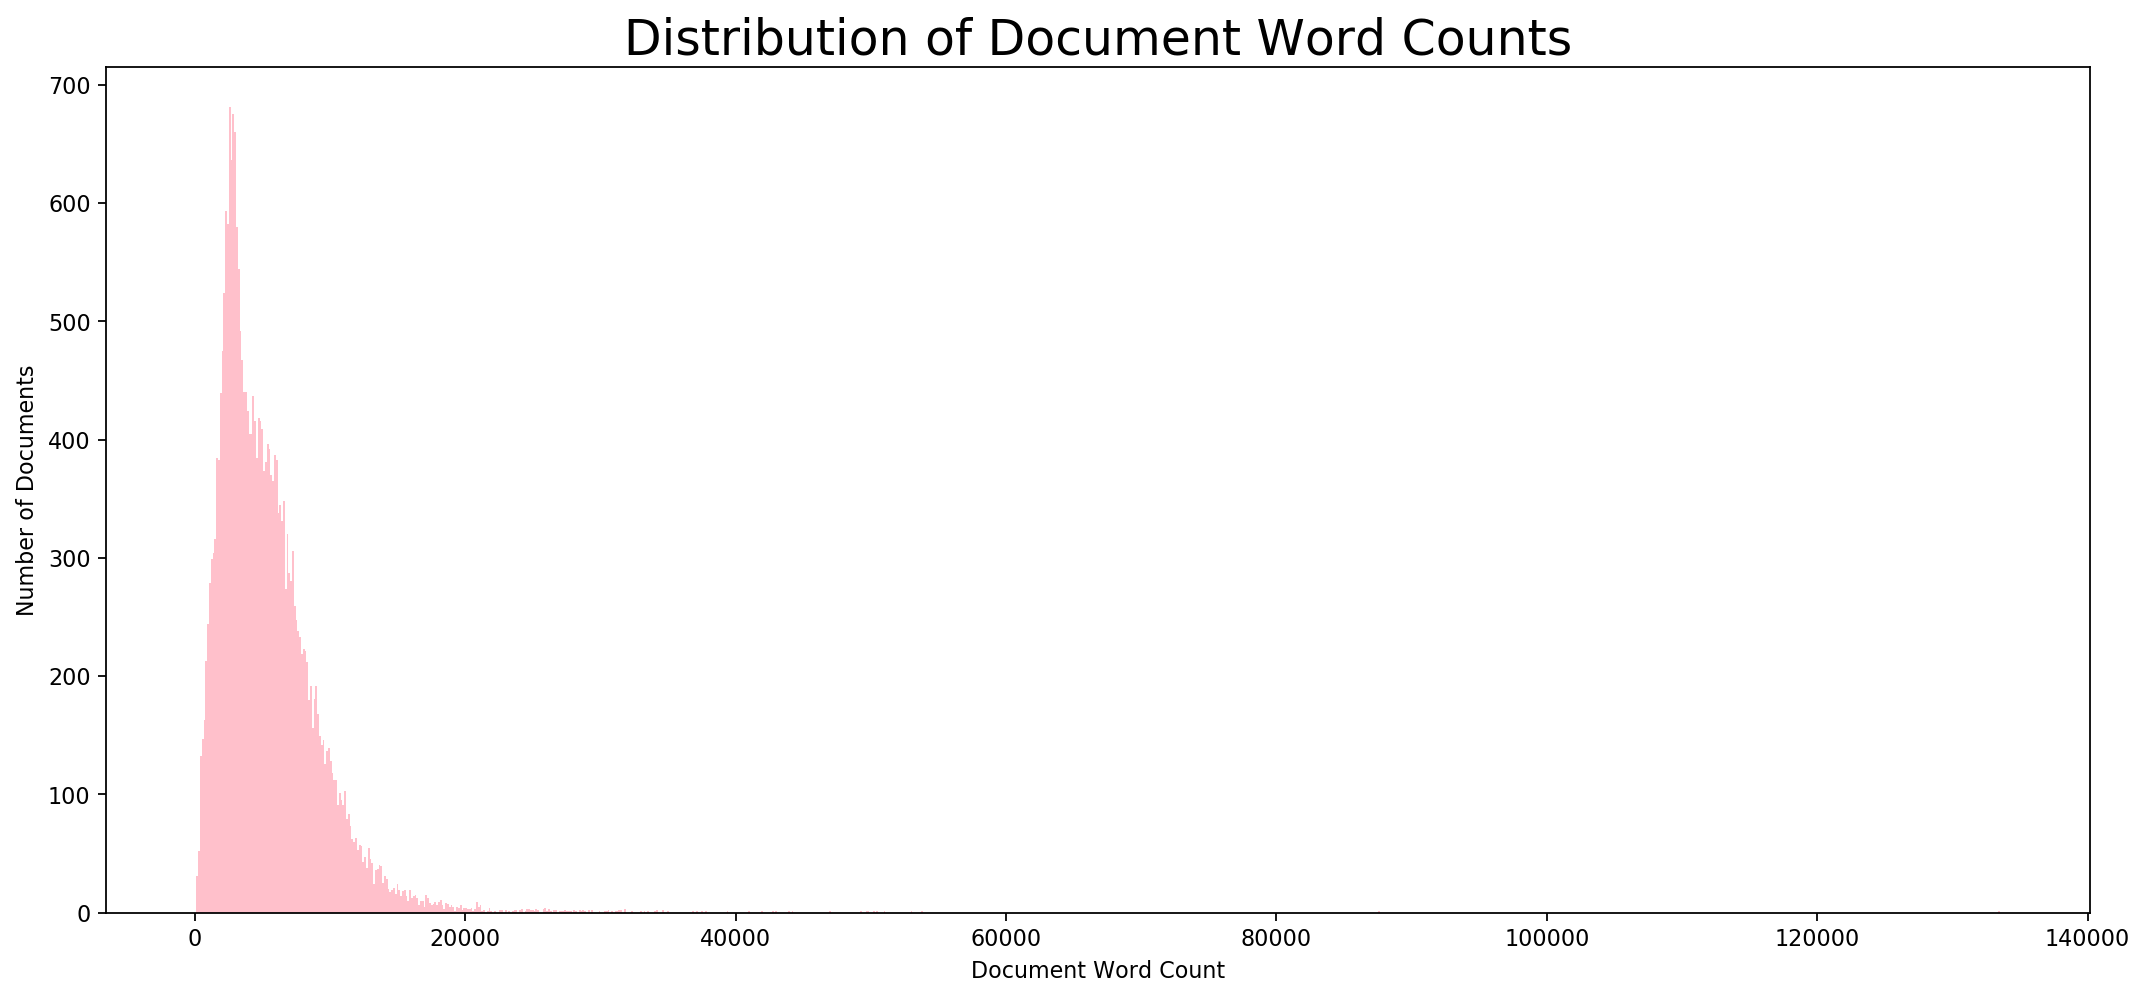

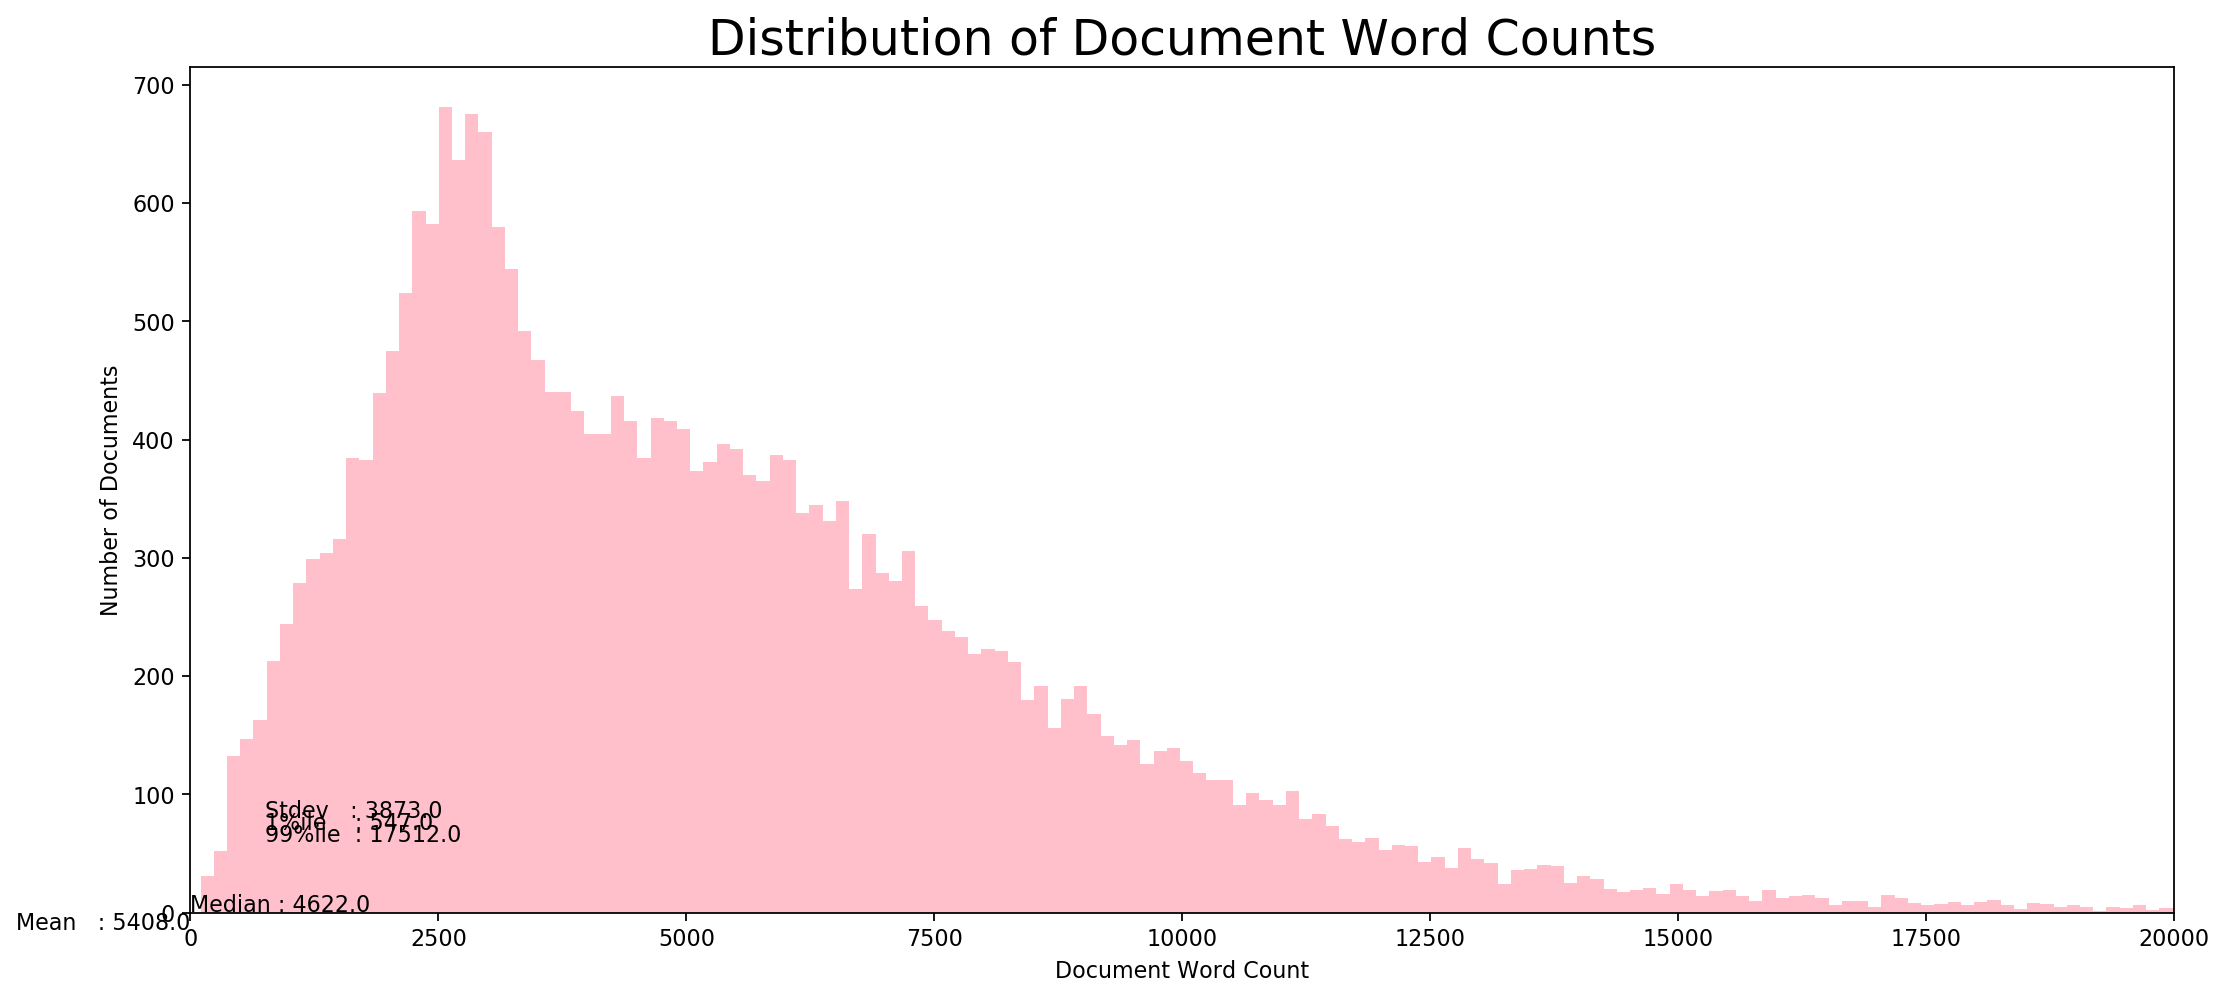

In [14]:
# VISUALIZE HOW BIG THE PAPERS ARE 
doc_lens = [len(d) for d in corpus_tokens]
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000, color='pink')
plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count')
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=1000, color='pink')
plt.text(0.5, 0.5, "Mean   : " + str(round(np.mean(doc_lens))), verticalalignment='top', horizontalalignment='right')
plt.text(0.5,  0.5, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 20000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

# Removing most frequent words

In [283]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)

In [299]:
for bow in corpus:
    for value in tfidf[bow]:
        print(value)

(0, 1.0)
(1, 1.0)
(2, 1.0)
(3, 1.0)
(4, 0.4206760390361345)
(5, 0.9072109292666554)
(6, 1.0)
(7, 1.0)
(8, 1.0)
(9, 0.0020506442249981875)
(10, 0.9999978974269208)
(11, 1.0)
(12, 1.0)
(13, 1.0)
(14, 1.0)
(15, 1.0)
(16, 0.9334848462417668)
(17, 0.3586168454450867)
(18, 1.0)
(19, 1.0)
(20, 1.0)
(21, 0.4874267693205318)
(22, 0.873163870387311)
(23, 0.5516566969421695)
(24, 0.8340712731648628)
(25, 1.0)
(26, 1.0)
(27, 1.0)
(28, 0.9612696918926567)
(29, 0.2756094690836961)
(30, 1.0)
(31, 1.0)
(32, 1.0)
(33, 1.0)
(34, 1.0)
(35, 1.0)
(36, 1.0)
(37, 1.0)
(38, 1.0)
(39, 0.18223471602346286)
(40, 0.983255057589763)
(41, 1.0)
(42, 1.0)
(43, 1.0)
(44, 1.0)
(45, 1.0)
(46, 1.0)
(47, 1.0)
(48, 1.0)
(49, 1.0)
(50, 1.0)
(51, 1.0)
(52, 1.0)
(53, 1.0)
(54, 1.0)
(55, 1.0)
(56, 1.0)
(57, 1.0)
(58, 0.0006438169836884806)
(59, 0.9943309094579824)
(60, 0.10632792669921254)
(61, 1.0)
(62, 1.0)
(63, 1.0)
(64, 1.0)
(65, 0.7430314925122533)
(66, 0.6692564539360178)
(67, 1.0)
(68, 1.0)
(69, 0.4115805889407327)
(70,

In [293]:
low_value = 0.05
low_value_words = []
for bow in corpus:
    low_value_words += [id for id, value in tfidf[bow] if value < low_value]

In [294]:
# Filter low-value words out of dictionary
dictionary.filter_tokens(bad_ids=low_value_words)

## Recommending papers with LDA

In [25]:
#gensim.corpora.MmCorpus.serialize('SerializedCorpus.mm', corpus)
#SerializedCorpus = gensim.corpora.MmCorpus('SerializedCorpus.mm')
lda_display = pyLDAvis.gensim.prepare(lda, SerializedCorpus, dictionary, sort_topics=False)
#pyLDAvis.save_html(vis_data,outpth+'LDA_Visualization.html')
pyLDAvis.display(lda_display)

KeyboardInterrupt: 

In [17]:
doc = corpus_df.iloc[0].text
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lda = lda[vec_bow]  # convert the query to LDA space
print(vec_lda)

[(1, 0.08331074), (2, 0.13134763), (5, 0.10267593), (6, 0.02467724), (7, 0.010721337), (8, 0.012411337), (9, 0.6330061)]


In [322]:
# Prepare for similarity queries
index = gensim.similarities.Similarity(corpus=lda[corpus], num_features=len(dictionary), output_prefix='similarities') # using Similarity instead of MatrixSimilarity due to memory
# index.save('similarities.index')

In [323]:
# Obtain similarity of our query against our indexed papers
sims = index[vec_lda]  # perform a similarity query against the corpus
print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 0.99442685), (1, 0.6211318), (2, 0.7009346), (3, 0.20347425), (4, 0.7102888), (5, 0.25829202), (6, 0.22165217), (7, 0.5104571), (8, 0.66891706), (9, 0.15706307), (10, 0.59238416), (11, 0.08689807), (12, 0.5703656), (13, 0.8627517), (14, 0.16462281), (15, 0.79554474), (16, 0.15178756), (17, 0.62685275), (18, 0.5866891), (19, 0.9739746), (20, 0.96223235), (21, 0.6814616), (22, 0.28636417), (23, 0.11833093), (24, 0.3407045), (25, 0.18465884), (26, 0.17823994), (27, 0.23004708), (28, 0.96877295), (29, 0.14906539), (30, 0.9029006), (31, 0.3682529), (32, 0.5236852), (33, 0.7074783), (34, 0.6497597), (35, 0.97173536), (36, 0.24265236), (37, 0.86969924), (38, 0.59843224), (39, 0.38972598), (40, 0.9602117), (41, 0.88079995), (42, 0.9557548), (43, 0.2688068), (44, 0.8312324), (45, 0.9560262), (46, 0.27320242), (47, 0.7187598), (48, 0.39870372), (49, 0.5079375), (50, 0.4372487), (51, 0.09803088), (52, 0.15071213), (53, 0.17788188), (54, 0.853574), (55, 0.67650217), (56, 0.1319629), (57, 0.14

/Users/briennakh/anaconda3/envs/gl-env/lib/python3.7/site-packages/gensim/similarities/docsim.py:528: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


In [324]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)  # print sorted (document number, similarity score) 2-tuples

[(2027, 0.9956573), (0, 0.99442685), (4456, 0.98994887), (249, 0.9889825), (1010, 0.98866224), (4662, 0.98833627), (3477, 0.9871902), (4005, 0.98600537), (4360, 0.9847261), (3678, 0.9840274), (730, 0.9836889), (3124, 0.9836481), (4357, 0.983458), (2854, 0.98327124), (2985, 0.98280525), (3255, 0.982538), (3099, 0.9825033), (3422, 0.982411), (3524, 0.9817847), (974, 0.98139393), (724, 0.9812952), (513, 0.9811848), (1429, 0.98101485), (1329, 0.9794426), (2410, 0.9793628), (598, 0.97927), (4924, 0.97868943), (3148, 0.9785446), (2748, 0.97851974), (1287, 0.97845966), (265, 0.9783464), (1039, 0.97815275), (585, 0.9775993), (3502, 0.9775802), (1990, 0.9774481), (75, 0.97725195), (2174, 0.9769855), (389, 0.9764579), (2251, 0.9764225), (4837, 0.9762192), (3167, 0.9761665), (172, 0.976003), (2636, 0.9759722), (4113, 0.9759606), (322, 0.9758017), (357, 0.97579455), (4474, 0.97560406), (4100, 0.9754299), (3085, 0.9752833), (4377, 0.974688), (2672, 0.9746368), (3537, 0.97437125), (2269, 0.9741194),

In [325]:
corpus_df.iloc[[2027]]

,arxiv_id,text
2039,0706.1809,introduction the spitzer legacy science progra...


In [326]:
corpus_df.iloc[[0]]

,arxiv_id,text
0,0704.0009,the serpens star forming cloud is one of five ...


Query was: https://arxiv.org/pdf/0704.0009.pdf

Result was: https://arxiv.org/pdf/0706.1809.pdf

They are similar!

## Compare subjects

In [18]:
metadata = pd.read_csv('arxiv_metadata_astroph.csv',
                           dtype={'filename': str,
                                  'filename_parsed': str,
                                  'identifier': str,
                                  'updated': str,
                                  'doi': str}, 
                           parse_dates=['date_retrieved'])
metadata

,abstract,authors,categories,comments,created,date_retrieved,datestamp,doi,filename,filename_parsed,identifier,journal,spec,title,updated
0,We discuss the results from the combined IRA...,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...",astro-ph,NaN,2007-04-02,2019-02-12 06:42:16+00:00,2010-03-18,10.1086/518646,0704.0009,0704.0009,oai:arXiv.org:0704.0009,"Astrophys.J.663:1149-1173,2007",physics:astro-ph,"The Spitzer c2d Survey of Large, Nearby, Inste...",NaN
1,Results from spectroscopic observations of t...,"Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...",astro-ph,NaN,2007-03-31,2019-02-12 06:42:16+00:00,2009-06-23,10.1111/j.1365-2966.2007.11762.x,0704.0017,0704.0017,oai:arXiv.org:0704.0017,"Mon.Not.Roy.Astron.Soc.378:211-220,2007",physics:astro-ph,Spectroscopic Observations of the Intermediate...,NaN
2,"The very nature of the solar chromosphere, i...","M. A. Loukitcheva, S. K. Solanki, S. White",astro-ph,NaN,2007-03-31,2019-02-12 06:42:16+00:00,2009-06-23,10.1007/s10509-007-9626-1,0704.0023,0704.0023,oai:arXiv.org:0704.0023,"Astrophys.Space Sci.313:197-200,2008",physics:astro-ph,ALMA as the ideal probe of the solar chromosphere,NaN
3,We present a theoretical framework for plasm...,"A. A. Schekochihin, S. C. Cowley, W. Dorland, ...",astro-ph nlin.CD physics.plasm-ph physics.spac...,NaN,2007-03-31,2019-02-12 06:42:16+00:00,2015-05-13,10.1088/0067-0049/182/1/310,0704.0044,0704.0044,oai:arXiv.org:0704.0044,"ApJS 182, 310 (2009)",physics:astro-ph,Astrophysical gyrokinetics: kinetic and fluid ...,2009-05-09
4,We report on the analysis of selected single...,"Alexander Stroeer, John Veitch, Christian Roev...",gr-qc astro-ph,NaN,2007-03-31,2019-02-12 06:42:16+00:00,2008-11-26,10.1088/0264-9381/24/19/S17,0704.0048,0704.0048,oai:arXiv.org:0704.0048,"Class.Quant.Grav.24:S541-S550,2007",physics:astro-ph,Inference on white dwarf binary systems using ...,2007-04-03
5,We derive masses and radii for both componen...,"T. G. Beatty, J. M. Fernandez, D. W. Latham, G...",astro-ph,NaN,2007-03-31,2019-02-12 06:42:16+00:00,2009-06-23,10.1086/518413,0704.0059,0704.0059,oai:arXiv.org:0704.0059,"Astrophys.J.663:573-582,2007",physics:astro-ph,The Mass and Radius of the Unseen M-Dwarf Comp...,2007-04-09
6,We show that the globular cluster mass funct...,"Dean E. McLaughlin, S. Michael Fall",astro-ph,NaN,2007-04-01,2019-02-12 06:42:16+00:00,2010-11-11,10.1086/533485,0704.0080,0704.0080,oai:arXiv.org:0704.0080,"Astrophys.J.679:1272-1287,2008",physics:astro-ph,Shaping the Globular Cluster Mass Function by ...,2008-06-11
7,We present semi-analytical constraint on the...,HongSheng Zhao,astro-ph,NaN,2007-04-02,2019-02-12 06:42:16+00:00,2007-05-23,NaN,0704.0094,0704.0094,oai:arXiv.org:0704.0094,NaN,physics:astro-ph,Timing and Lensing of the Colliding Bullet Clu...,NaN
8,Context. Swift data are revolutionising our ...,"P. A. Evans, A. P. Beardmore, K. L. Page, L. G...",astro-ph,NaN,2007-04-02,2019-02-12 06:42:16+00:00,2009-11-13,10.1051/0004-6361:20077530,0704.0128,0704.0128,oai:arXiv.org:0704.0128,NaN,physics:astro-ph,An online repository of Swift/XRT light curves...,2007-04-19
9,We report the first detection of the 6.2micr...,"D. Lutz, E. Sturm, L. J. Tacconi, E. Valiante,...",astro-ph,NaN,2007-04-02,2019-02-12 06:42:16+00:00,2009-11-13,10.1086/518537,0704.0133,0704.0133,oai:arXiv.org:0704.0133,NaN,physics:astro-ph,PAH emission and star formation in the host of...,NaN


Add subject to each article in corpus:

In [19]:
for i, paper in enumerate(corpus_df.itertuples(), 1):
    corpus_df.loc[i, 'main_category'] = metadata.loc[metadata['filename_parsed'] == paper.arxiv_id]['categories'].str.split().tolist()[0][0]

In [20]:
# Will need to save this in the future, not now
corpus_df

,arxiv_id,text,main_category
0,1304.4591,massive stars strongly contribute to the light...,NaN
1,1709.01527,temporal monitoring of neighboring stars e g w...,astro-ph.SR
2,1406.2086,methanol masers are known to be associated wit...,astro-ph.EP
3,1206.3042,meteorites are a partial sample of asteroids t...,astro-ph.GA
4,1403.1103,among the alternative approaches to describe t...,astro-ph.EP
5,0902.1212,r coronae borealis rcb stars are a type of eru...,astro-ph.CO
6,astro-ph0404318,the wmap satellite measured an optical depth t...,astro-ph.SR
7,1608.08842,the object v838 monocerotis hereafter v838 mon...,astro-ph
8,1403.6120,the discovery of cosmic acceleration has gener...,astro-ph.SR
9,0809.4871,although sirius is the brightest star in the s...,hep-th


## Extra

In [276]:
# Find dominant topic of each document and its percentage contribution in the document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=MyCorpus(), texts=dictionary)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,48.0,0.1375,"the, <num>, of, in, <latex>, and, to, a, is, with",0
1,1,64.0,0.2087,"the, of, <latex>, <num>, and, a, in, to, is, that",1
2,2,7.0,0.3479,"the, of, <num>, in, <latex>, and, to, a, is, for",2
3,3,43.0,0.3800,"the, <latex>, of, in, and, to, is, a, <num>, for",3
4,4,7.0,0.1815,"the, of, <num>, in, <latex>, and, to, a, is, for",4
5,5,75.0,0.5230,"the, of, <latex>, in, a, and, is, to, <num>, we",5
6,6,43.0,0.2866,"the, <latex>, of, in, and, to, is, a, <num>, for",6
7,7,51.0,0.1256,"the, <num>, of, to, and, in, <latex>, a, for, is",7
8,8,32.0,0.3493,"the, <num>, of, and, <latex>, is, to, a, in, for",8
9,9,90.0,0.6471,"the, <latex>, of, in, to, a, and, is, we, for",9


In [277]:
for idx, topic in lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.071*"the" + 0.052*"<latex>" + 0.029*"<num>" + 0.028*"of" + 0.024*"and" + 0.024*"in" + 0.017*"a" + 0.014*"to" + 0.013*"for" + 0.013*"is"


Topic: 1 
Words: 0.057*"the" + 0.038*"<num>" + 0.034*"<latex>" + 0.026*"of" + 0.025*"in" + 0.021*"and" + 0.017*"to" + 0.015*"is" + 0.014*"a" + 0.010*"we"


Topic: 2 
Words: 0.092*"the" + 0.040*"of" + 0.036*"<num>" + 0.021*"and" + 0.021*"<latex>" + 0.020*"to" + 0.019*"a" + 0.017*"in" + 0.014*"that" + 0.013*"is"


Topic: 3 
Words: 0.064*"the" + 0.029*"of" + 0.026*"<latex>" + 0.025*"<num>" + 0.021*"to" + 0.020*"in" + 0.019*"a" + 0.018*"and" + 0.015*"is" + 0.011*"that"


Topic: 4 
Words: 0.063*"the" + 0.047*"<num>" + 0.032*"of" + 0.023*"<latex>" + 0.018*"in" + 0.017*"and" + 0.014*"that" + 0.014*"is" + 0.014*"a" + 0.013*"to"


Topic: 5 
Words: 0.073*"the" + 0.043*"of" + 0.041*"<num>" + 0.027*"<latex>" + 0.024*"in" + 0.022*"a" + 0.017*"to" + 0.015*"is" + 0.015*"and" + 0.011*"that"


Topic: 6 
Words: 0.073*"the" + 0.034*"of" + 0.029*"<num

In [280]:
x=lda.show_topics(num_topics=10, num_words=100,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))

0::['the', '<latex>', '<num>', 'of', 'and', 'in', 'a', 'to', 'for', 'is', 'that', 'by', 'we', 'with', 'are', 'be', 'at', 'on', 'as', 'this', 'it', 'can', 'which', 'have', 'from', 'an', 'et', 'not', 'al', 'field', 'these', 'where', 'mass', 'than', 'model', 'energy', 'also', 'our', 'density', 'stars', 's', 'h', 'time', 'or', 'two', 'more', 'i', 'see', 'will', 'using', 'one', 'data', 'all', 'large', 'has', 'if', 'galaxies', 'gas', 'e', 'such', 'between', 'but', 'emission', 'magnetic', 'observed', 'line', 'only', 'was', 'range', 'high', 'were', 'value', 'star', 'may', 'used', 'figure', 'due', 'found', 'other', 'been', 'x', 'their', 'case', 'values', 'however', 'spectrum', 'when', 'both', 'sources', 'very', 'would', 'm', 'cluster', 'its', 'number', 'results', 'while', 'fig', 'region', 'source']
1::['the', '<num>', '<latex>', 'of', 'in', 'and', 'to', 'is', 'a', 'we', 'with', 'that', 'by', 'are', 'et', 'al', 'for', 'be', 'as', 'from', 'on', 'at', 'this', 'galaxies', 'have', 'which', 'stars', 

In [109]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()